# Setup

In [1]:
import gc
gc.enable()

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import (
    image_dataset_from_directory,
    set_random_seed
)

In [2]:
SEED = 2024
set_random_seed(SEED)

# Loading the data

In [3]:
# train directory will be used for training and validation + overfitting-detection
TRAIN_DIR = '/kaggle/input/animals/animals/train'

# val directory will be used as a replacement for test set
# since inf directory has only 5 images for testing
TEST_DIR = '/kaggle/input/animals/animals/val'

In [4]:
# loading parameters
BATCH_SIZE = 32
IMG_SIZE = 256
VAL_SPLIT = 0.2

In [5]:
train_ds = image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=VAL_SPLIT,
    subset='training',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED    
)

Found 13474 files belonging to 5 classes.
Using 10780 files for training.


In [6]:
val_ds = image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=VAL_SPLIT,
    subset='validation',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED    
)

Found 13474 files belonging to 5 classes.
Using 2694 files for validation.


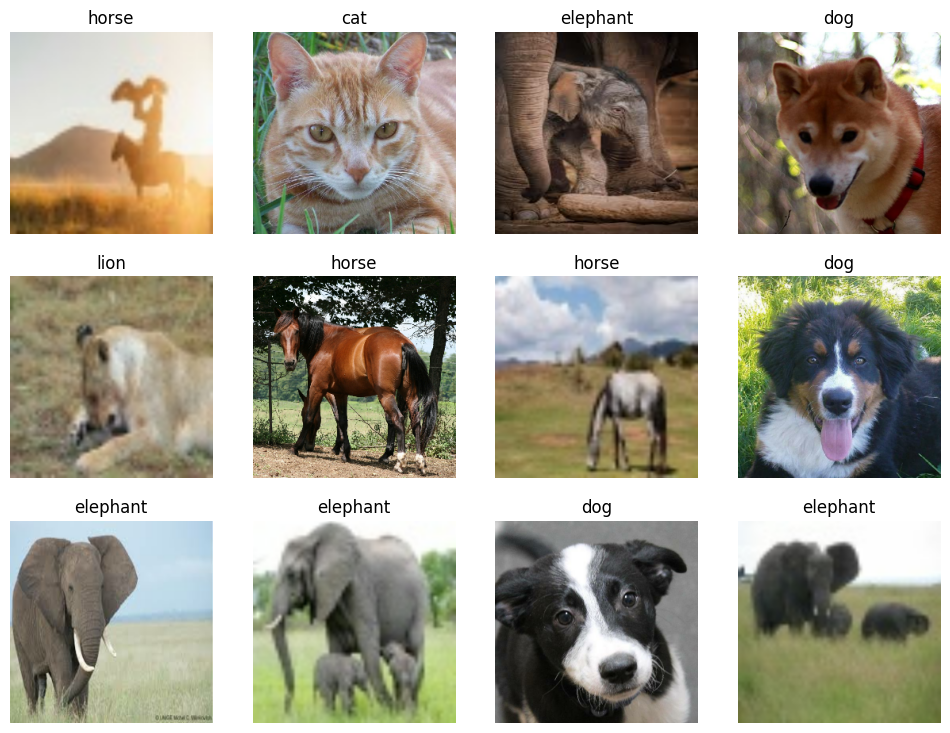

In [7]:
class_names = train_ds.class_names
plt.figure(figsize=(12, 9))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Modeling

In [9]:
keras.backend.clear_session()

In [10]:
num_classes = len(class_names)

data_augmentation = Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1)
])

model = Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [11]:
model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [12]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,412,965 (32.09 MB)

 Trainable params: 8,412,965 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=5e-4,
    patience=20,
    verbose=0,
    mode='max',
    restore_best_weights=True
)

In [14]:
EPOCHS = 200

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[early_stopping],
    epochs=EPOCHS
)

Epoch 1/200


2024-08-26 13:49:43.589131: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


337/337 ━━━━━━━━━━━━━━━━━━━━ 45s 48ms/step - accuracy: 0.3278 - loss: 1.5407 - val_accuracy: 0.5947 - val_loss: 0.9957
Epoch 2/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.6204 - loss: 0.9685 - val_accuracy: 0.6845 - val_loss: 0.8087
Epoch 3/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.6928 - loss: 0.7884 - val_accuracy: 0.7324 - val_loss: 0.6717
Epoch 4/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.7123 - loss: 0.7366 - val_accuracy: 0.7253 - val_loss: 0.7122
Epoch 5/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.7402 - loss: 0.6590 - val_accuracy: 0.7613 - val_loss: 0.5935
Epoch 6/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.7454 - loss: 0.6398 - val_accuracy: 0.7621 - val_loss: 0.6255
Epoch 7/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.7667 - loss: 0.6003 - val_accuracy: 0.7617 - val_loss: 0.5764
Epoch 8/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.7745 - loss: 0.5855 - val_

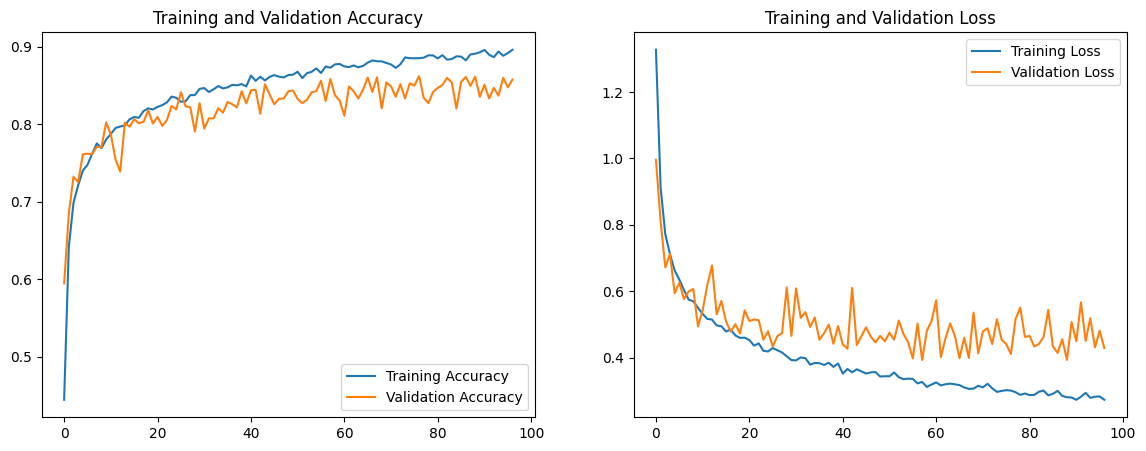

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()